# Pianist classification using melodic and rhythmic features

## Import dependencies and set constants, etc.

In [2]:
import os
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from src import utils
from src.detect.midi_utils import *
from src.features.melody_features import *
from src.features.rhythm_features import *

C:\Python Projects\jazz-corpus-analysis\venv\lib\site-packages\piano_transcription_inference\inference.py:18: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf . Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem . (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:84.)
  segment_samples=16000*10, device=torch.device('cuda')):
C:\Python Projects\jazz-corpus-analysis\venv\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
smallest_n_gram = 3
largest_n_gram = 10

## Pre-processing

In [3]:
# Get filepaths for processing
root = f'{utils.get_project_root()}/data/cambridge-jazz-trio-database-v01/corpus_chronology'
files = [os.path.join(root, f) for f in os.listdir(root)]

In [4]:
# Load in onsets and beats for each track
oms = [utils.load_track_from_files(f) for f in files]

C:\Python Projects\jazz-corpus-analysis\src\utils.py:710: UserWarning: genfromtxt: Empty input file: "C:\Python Projects\jazz-corpus-analysis/data/cambridge-jazz-trio-database-v01/corpus_chronology\evansb-allofyou-gomezezigmunde-1976-acbb08b7/bass.csv"
  om.ons[instr] = np.genfromtxt(rf'{trackpath}/{instr}.csv', delimiter=',')
C:\Python Projects\jazz-corpus-analysis\src\utils.py:710: UserWarning: genfromtxt: Empty input file: "C:\Python Projects\jazz-corpus-analysis/data/cambridge-jazz-trio-database-v01/corpus_chronology\evansb-oneforhelen-gomezedejohnettej-1967-94d467a6/bass.csv"
  om.ons[instr] = np.genfromtxt(rf'{trackpath}/{instr}.csv', delimiter=',')
C:\Python Projects\jazz-corpus-analysis\src\utils.py:710: UserWarning: genfromtxt: Empty input file: "C:\Python Projects\jazz-corpus-analysis/data/cambridge-jazz-trio-database-v01/corpus_chronology\jamala-likesomeoneinlove-nasserjfournierv-1966-c56d6b55/bass.csv"
  om.ons[instr] = np.genfromtxt(rf'{trackpath}/{instr}.csv', delimiter='

In [5]:
# Extract melody for each track
mms = [MelodyMaker(os.path.join(fp, 'piano_midi.mid'), om) for fp, om in zip(files, oms)]

## Create histogram of pitch classes for one track

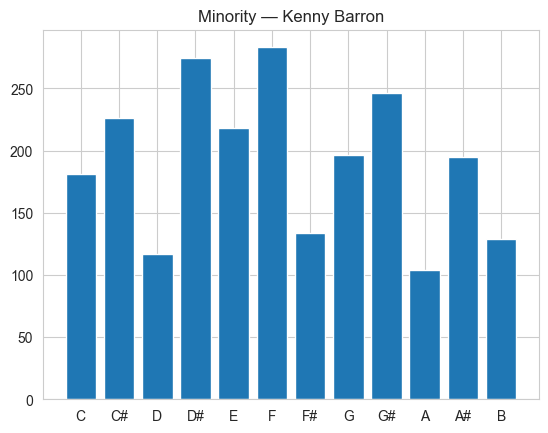

In [ ]:
# Create a histogram for the pitch classes in one track
# Extract the melody for our first track
mel = list(mms[15].extract_melody())
# Count the pitch classes
pitch_classes = Counter([m.note for m in mel])
# Sort the pitch classes in order of the piano keys
sorted_pitches = {i: pitch_classes[i] for i in utils.ALL_PITCHES}
# Create the bar chart
plt.bar(sorted_pitches.keys(), sorted_pitches.values())
plt.title(oms[15].item['track_name'] + ' — ' + oms[15].item['pianist'])
plt.show()

## Visualise tonalness across all chunks

In [ ]:
tonalness = []
for melody, onsets in zip(mms, oms):
    mel = list(melody.extract_melody())
    for chunk in melody.chunk_melody(mel):
        if len(chunk) < 2:
            continue
        ton = TonalityExtractor(chunk)
        tonalness.append(dict(**onsets.item, **ton.summary_dict))

In [ ]:
ton_df = pd.DataFrame(tonalness)

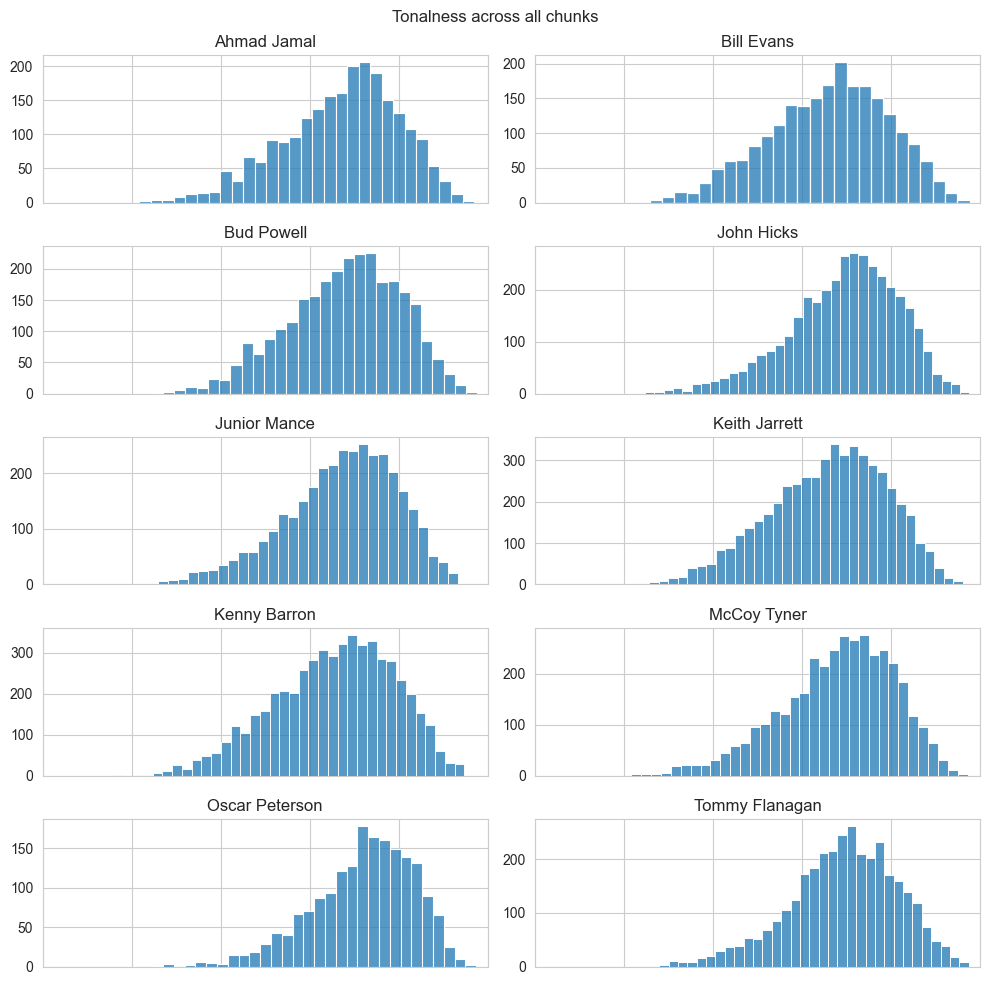

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
for a, (idx, grp) in zip(ax.flatten(), ton_df.groupby('pianist')):
    sns.histplot(grp['tonalness'], ax=a)
    a.set(title=idx, xlim=(0, 1), ylabel='', xlabel='', xticklabels=[])
plt.suptitle('Tonalness across all chunks')
plt.tight_layout()
plt.show()

## N-gram extraction

In [ ]:
pianists = set([om.item['pianist'] for om in oms])
counters = {pi: {n: {} for n in range(smallest_n_gram, largest_n_gram + 1)} for pi in pianists}

for mm, om in tqdm(zip(mms, oms)):
    intervals = list(mm.extract_intervals())
    pianist = om.item['pianist']
    for start in range(len(intervals)):
        for n in counters[pianist].keys():
            n_gram = tuple([i.interval for i in intervals[start: start + n]])
            if len(n_gram) == n:
                try:
                    counters[pianist][n][n_gram] += 1
                except KeyError:
                    counters[pianist][n][n_gram] = 1

0it [00:00, ?it/s]


KeyboardInterrupt



## Visualise top 10 3-grams for each pianist

In [ ]:
all_3grams = []
for pi in pianists:
    grams_3 = counters[pi][3]
    top_10 = {i: k for i, k in sorted(grams_3.items(), key=lambda x: x[1], reverse=True)[:5]}
    for i, k in top_10.items():
        all_3grams.append(dict(pianist=pi, ngram=i, num=k))
df_3grams = pd.DataFrame(all_3grams)

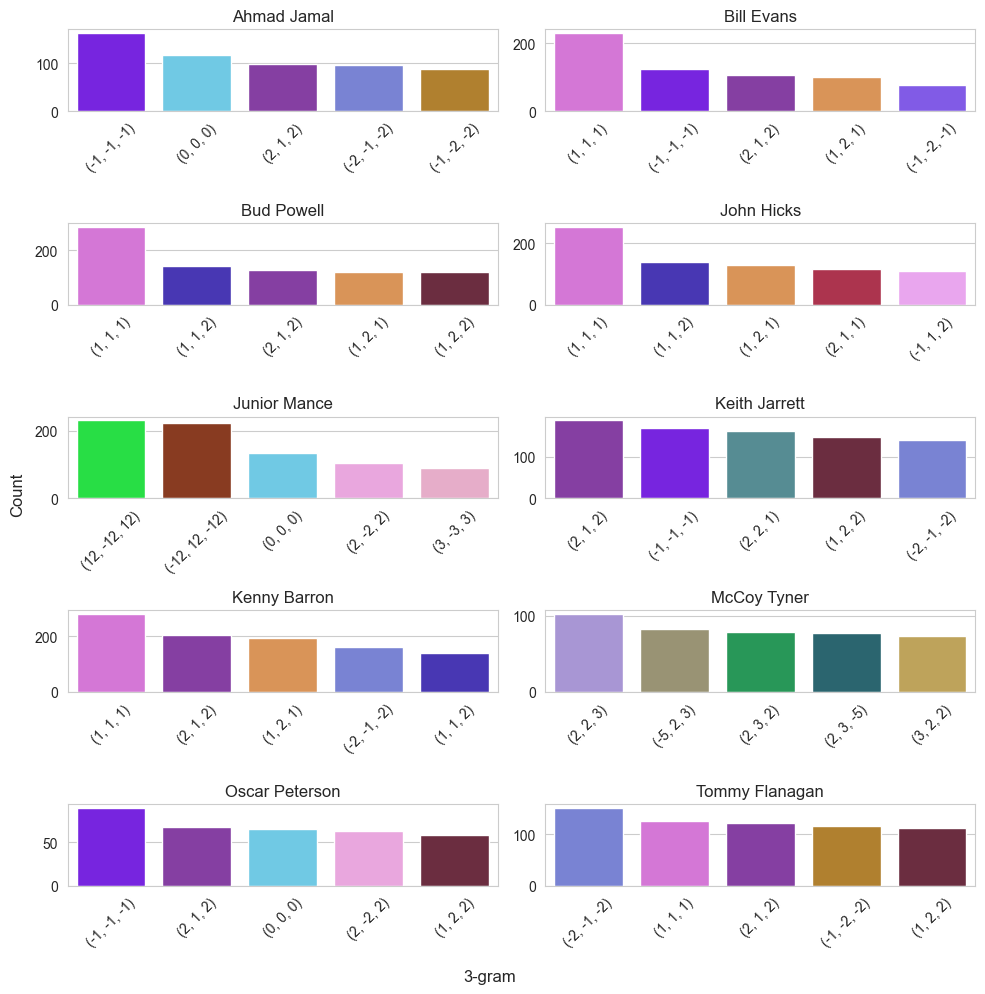

In [ ]:
import random
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
colors = {}

rand_col = lambda: random.randint(0,255)
for a, (idx, grp) in zip(ax.flatten(), df_3grams.groupby('pianist')):
    cols = []
    for i, r in grp.iterrows():
        try:
            cols.append(colors[r['ngram']])
        except KeyError:
            colors[r['ngram']] = '#%02X%02X%02X' % (rand_col(),rand_col(),rand_col())
            cols.append(colors[r['ngram']])

    sns.barplot(grp, x='ngram', y='num', ax=a, palette=cols)
    a.set_xticklabels(a.get_xticklabels(), rotation=45)
    a.set(title=idx, xlabel='', ylabel='')
fig.supxlabel('3-gram')
fig.supylabel('Count')
plt.tight_layout()
plt.show()

## N-gram extraction from chunks

In [6]:
dicts = []
for melody, onsets in tqdm(zip(mms, oms)):
    mel = list(melody.extract_melody())
    intervals = list(melody.extract_intervals(mel))
    for chunk in melody.chunk_melody(intervals, overlapping_chunks=False):
        if len(chunk) < 2:
            continue
        counter = {'pianist': onsets.item['pianist'], 'track_name': onsets.item['track_name']}
        for start in range(len(chunk)):
            # for n in range(smallest_n_gram, largest_n_gram + 1):
            for n in range(smallest_n_gram, 4):
                n_gram = tuple([i.interval for i in intervals[start: start + n]])
                if len(n_gram) == n:
                    try:
                        counter[str(n_gram)] += 1
                    except KeyError:
                        counter[str(n_gram)] = 1
        dicts.append(counter)

0it [00:00, ?it/s]

In [1]:
import json
with open(f'{utils.get_project_root()}/models/3grams.json', 'wb') as fp:
    json.write(dicts, fp, indent=4, ensure_ascii=False)

NameError: name 'utils' is not defined

In [7]:
chunks = pd.DataFrame(dicts)

In [9]:
print(chunks.head())

KeyboardInterrupt: 

In [1]:
import pandas as pd
chunks = (
    pd.read_json(f'ngrams.json')
    .fillna(0)
    .set_index(['pianist', 'track_name'])
)
chunks = chunks.div(chunks.sum(axis=1), axis=0)

In [ ]:
chunks.shape

## PCA dimensionality reduction

In [2]:
from sklearn.decomposition import PCA

for nc in range(50, 500, 50):
  pca = PCA(n_components=nc)
  pca.fit(chunks.to_numpy())
  print(nc, sum(pca.explained_variance_ratio_))

50 0.3508976486982349
100 0.5334128848985822
150 0.6564744008070248
200 0.7448198450643307
250 0.8107436275275045
300 0.8571738028755659
350 0.8877766137947203
400 0.9074116187641978
450 0.9209445410831282


300 components are enough to explain 85% of the data in the original set


In [6]:
reduced = PCA(n_components=300).fit_transform(chunks.to_numpy())
print(reduced)

[[-4.63471700e-03 -6.70970844e-03 -1.73076295e-03 ...  2.01164493e-03
  -2.09682183e-03  5.91563992e-03]
 [-4.42947686e-03 -6.66744616e-03 -1.50113374e-03 ... -1.87381781e-04
   1.07431195e-03 -2.33006746e-03]
 [-4.84970910e-03 -6.37306865e-03 -1.83144071e-03 ...  7.71234398e-04
  -1.46196826e-03  3.25576027e-03]
 ...
 [-2.32002292e-03 -7.56258806e-04 -2.82414103e-03 ... -7.45341645e-04
  -2.30347159e-03  2.80999923e-04]
 [-2.25545874e-03 -6.45176377e-04 -2.39984870e-03 ... -1.04216100e-04
  -1.87688478e-03  3.03574708e-05]
 [-1.95226279e-03 -3.43164838e-04 -2.27642854e-03 ... -3.84587302e-05
  -1.38526364e-03 -3.32710479e-05]]


In [12]:
reduced_df = pd.DataFrame(reduced).set_index(chunks.index).reset_index(drop=False)

pianist
Ahmad Jamal        586
Bill Evans         570
Bud Powell         700
John Hicks         930
Junior Mance       858
Keith Jarrett     1296
Kenny Barron      1331
McCoy Tyner        952
Oscar Peterson     472
Tommy Flanagan     851
Name: track_name, dtype: int64

# Model fitting

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

X = chunks.reset_index(drop=False).iloc[:, 2:].to_numpy()
y = chunks.reset_index(drop=False).iloc[:, 0].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42, verbose=1)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
print(f1_score(y_test, y_predict))


# rf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42, verbose=1)
# cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True, )

# for train_idx, test_idx in cv.split(X, y):
#   train_X, train_y = X[train_idx], y[train_idx]
#   test_X, test_y = X[test_idx], y[test_idx]
  # rf.fit(train_X, train_y)
  # predict_y = rf.predict(test_X)
  # print(accuracy_score(test_y, predict_y))


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].